<a href="https://colab.research.google.com/github/Mashiat12/Synthetic_Brain_Image_Generation/blob/main/with_15_epoch(all_work).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
random.seed(0)
import numpy as np
np.random.seed(0)
import tensorflow as tf
tf.random.set_seed(0)
!pip install matplotlib-venn
!pip install tensorflow
import os
import json
from zipfile import ZipFile
from __future__ import print_function
import time
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.autograd import Variable
import matplotlib.pyplot as plt
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm_notebook as tqdm
from __future__ import print_function
import argparse
import torch.backends.cudnn as cudnn
import matplotlib.animation as animation
import pandas as pd
from PIL import Image
import time
import glob
import imageio
import cv2
import pathlib
import sys


import torchvision
from torch.utils.data import Dataset, DataLoader, ConcatDataset, TensorDataset
from torchvision.utils import make_grid
import torch.optim as optim
from torchvision.datasets import MNIST

from skimage import io, transform

from IPython import display
from IPython.display import HTML
manualSeed = 999
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU.")
        return torch.device('cuda')
    else:
        print("CUDA is not available. Using CPU.")
        return torch.device('cpu')

device = get_default_device()

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

CUDA is available. Using GPU.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
kaggle_credentails= json.load(open("/content/drive/MyDrive/kaggle.json"))
os.environ['KAGGLE_USERNAME'] = kaggle_credentails['username']
os.environ['KAGGLE_KEY'] = kaggle_credentails['key']
!kaggle datasets download -d ashfakyeafi/brain-mri-images
from zipfile import ZipFile
with ZipFile("/content/brain-mri-images.zip",'r') as zip_ref:
  zip_ref.extractall()
print(os.listdir("/content/GAN-Traning Images"))
print(len(os.listdir("/content/GAN-Traning Images")))

Mounted at /content/drive
Dataset URL: https://www.kaggle.com/datasets/ashfakyeafi/brain-mri-images
License(s): apache-2.0
 97% 339M/348M [00:03<00:00, 130MB/s]
100% 348M/348M [00:03<00:00, 107MB/s]
['OAS2_0102_MR2_x_slice_107.jpg', 'Tr-me_0039.jpg', 'OAS2_0064_MR2_z_slice_150.jpg', 'Tr-gl_1183.jpg', 'OAS2_0169_MR1_y_slice_100.jpg', 'Tr-gl_0121.jpg', 'Tr-no_1162.jpg', 'Tr-me_0100.jpg', 'Te-no_0294.jpg', 'Tr-no_0461.jpg', 'Tr-me_0359.jpg', 'OAS2_0101_MR1_y_slice_111.jpg', 'Te-no_0176.jpg', 'OAS2_0046_MR2_z_slice_130.jpg', 'Tr-no_0655.jpg', 'Tr-gl_1143.jpg', 'OAS2_0144_MR2_z_slice_122.jpg', 'Tr-pi_0241.jpg', 'OAS2_0104_MR2_x_slice_144.jpg', 'OAS2_0128_MR1_y_slice_139.jpg', 'Tr-me_1022.jpg', 'Tr-me_0211.jpg', 'OAS2_0037_MR3_z_slice_140.jpg', 'OAS2_0081_MR1_z_slice_132.jpg', 'Tr-no_1215.jpg', 'Tr-no_1213.jpg', 'Tr-me_0333.jpg', 'OAS2_0090_MR1_x_slice_113.jpg', 'Tr-gl_1229.jpg', 'Te-me_0014.jpg', 'OAS2_0069_MR1_x_slice_143.jpg', 'OAS2_0066_MR2_x_slice_135.jpg', 'OAS2_0185_MR3_x_slice_112.jp

In [ ]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)

    if img is None:
        print(f"Error: Could not load image at {img_path}. Please check the file path.")
        return None

    # Convert to grayscale (optional depending on your images)
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Denoising the image (adjusting parameters as you provided)
    denoised_img = cv2.fastNlMeansDenoising(gray_img, None, 20, 3, 21)

    # Sharpening using a custom kernel
    kernel_sharpen = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened_img = cv2.filter2D(denoised_img, -1, kernel_sharpen)

    return sharpened_img

# Preprocess all images in the dataset
def preprocess_dataset(image_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        processed_img = preprocess_image(img_path)

        if processed_img is not None:
            output_path = os.path.join(output_dir, img_name)
            cv2.imwrite(output_path, processed_img)

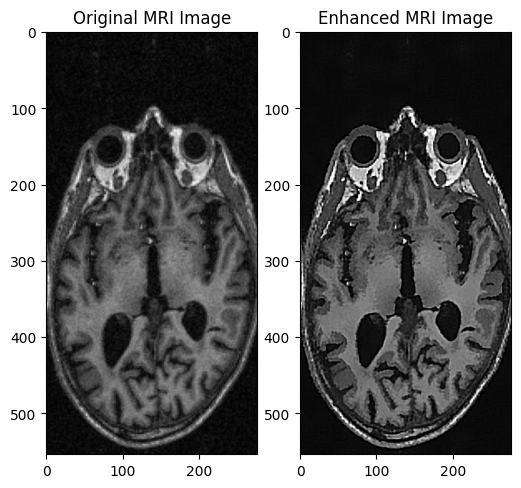

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(6, 6))
img_path = '/content/GAN-Traning Images/OAS2_0001_MR2_y_slice_105.jpg'
img1=mpimg.imread(img_path)
ax[0].imshow(img1 , cmap='gray')
ax[0].set_title('Original MRI Image')
ax[0].axis('on')
preprocessed_img = preprocess_image(img_path)
# Enhanced Image
ax[1].imshow(preprocessed_img, cmap='gray')
ax[1].set_title('Enhanced MRI Image')
ax[1].axis('on')

plt.show()


In [ ]:

image_dir = "/content/GAN-Traning Images"
output_dir = "/content/processed_images"

# Preprocess the dataset
preprocess_dataset(image_dir, output_dir)

In [ ]:
import shutil

# Specify the source directory where your generated images are stored
source_dir = '/content/processed_images'

# Specify the destination directory in your Google Drive
destination_dir = '/content/drive/My Drive/output_brain/'

# Copy the folder to Google Drive
shutil.copytree(source_dir, destination_dir)

'/content/drive/My Drive/output_brain/'

In [ ]:
def convert_to_tensor(img_path):
    img = Image.open(img_path).convert('L')  # Convert to grayscale if necessary
    transform = T.Compose([
        T.Resize((64, 64)),  # Resize to 64x64
        T.ToTensor(),        # Convert to Tensor
        T.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
    ])

    img_tensor = transform(img)
    return img_tensor

In [ ]:
# Example of converting all preprocessed images into tensors
def load_and_convert_images(image_dir):
    tensors = []

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        img_tensor = convert_to_tensor(img_path)
        tensors.append(img_tensor)

    return tensors


In [ ]:
# Load the preprocessed dataset as tensors
import torchvision.transforms as T
preprocessed_tensors = load_and_convert_images(destination_dir)

In [ ]:
# Assuming you have a DataLoader for your GAN
from torch.utils.data import DataLoader, TensorDataset

# Create a dataset from the tensors
preprocessed_dataset = TensorDataset(torch.stack(preprocessed_tensors))

In [ ]:
DATA_DIR = '/content/drive/MyDrive/out'
#images = os.listdir(PATH)
#img=mpimg.imread(images)
#print(img.shape)
#plt.imshow(img)
print(os.listdir(DATA_DIR))
device

['output_brain']


device(type='cuda')

In [ ]:
image_size=64
batch_size=128
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)
device

device(type='cuda')

In [ ]:
from torchvision.datasets import ImageFolder
train_ds= ImageFolder(DATA_DIR,transform=T.Compose([T.Resize(image_size),T.CenterCrop(image_size),T.ToTensor(),T.Normalize(*stats)]))
train_dl =DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)
device

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


device(type='cuda')

In [ ]:
def denorm(img_tensors):
  return img_tensors * stats[1][0]+stats[0][0]
device

device(type='cuda')

In [ ]:
def show_images(images,nmax=64):
  fig,ax=plt.subplots(figsize=(8,8))
  ax.set_xticks([]);
  ax.set_yticks([])
  ax.imshow(make_grid(denorm(images.detach()[:nmax]),nrow=8).permute(1,2,0))

def show_batch(dl,nmax=64):
  for images,_ in dl:
    show_images(images,nmax)
    break

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


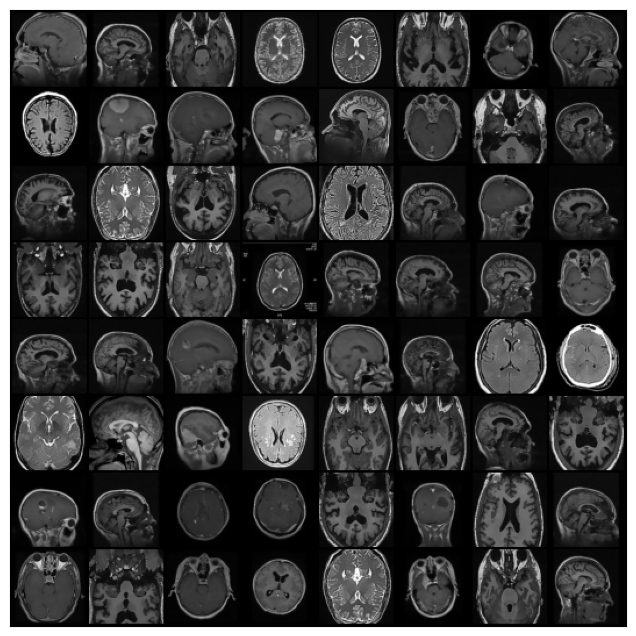

In [ ]:
show_batch(train_dl)

In [ ]:
discriminator =nn.Sequential(
    nn.Conv2d(3,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1,kernel_size=4,stride=1,padding=0,bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)
device

device(type='cuda')

In [ ]:
discriminator = to_device(discriminator,device)
device

device(type='cuda')

In [ ]:
latent_size=128
device

device(type='cuda')

In [ ]:
generator=nn.Sequential(
    nn.ConvTranspose2d(latent_size,512,kernel_size=4,stride=1,padding=0,bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),

    nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),

    nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1,bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),

    nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1,bias=False),
    nn.Tanh(),
)
device

device(type='cuda')

In [ ]:
xb=torch.randn(batch_size,latent_size,1,1)
print(xb.shape)
device

torch.Size([128, 128, 1, 1])


device(type='cuda')

torch.Size([128, 3, 64, 64])


device(type='cuda')

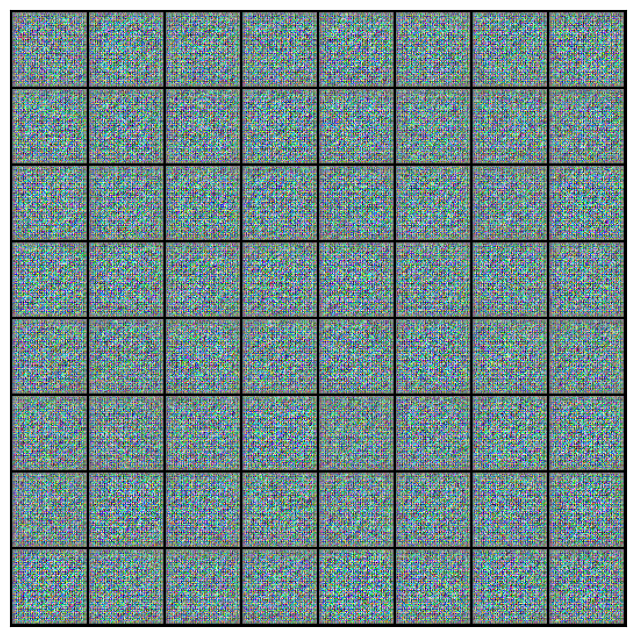

In [ ]:
fake_images=generator(xb)
print(fake_images.shape)
show_images(fake_images)
device

In [ ]:
generator=to_device(generator,device)

In [ ]:
def train_discriminator(real_images,opt_d):
  opt_d.zero_grad()
  real_images=real_images.to(device)
  real_preds= discriminator(real_images)
  real_targets=torch.ones(real_images.size(0),1,device=device)
  real_loss= F.binary_cross_entropy(real_preds,real_targets)
  real_score=torch.mean(real_preds).item()

  latent=torch.randn(batch_size,latent_size,1,1,device=device)
  fake_images=generator(latent)

  fake_targets= torch.zeros(fake_images.size(0),1,device=device)
  fake_preds= discriminator(fake_images)
  fake_loss= F.binary_cross_entropy(fake_preds,fake_targets)
  fake_score=torch.mean(fake_preds).item()

  loss=real_loss + fake_loss
  loss.backward()
  opt_d.step()
  return loss.item(),real_score,fake_score

In [ ]:
def train_generator(opt_g):
  opt_g.zero_grad()

  latent=torch.randn(batch_size,latent_size,1,1,device=device)
  fake_images=generator(latent)
  preds= discriminator(fake_images)
  targets=torch.ones(batch_size,1,device=device)
  loss= F.binary_cross_entropy(preds,targets)
  loss.backward()
  opt_g.step()
  return loss.item()

In [ ]:
sample_dir='generated'
os.makedirs(sample_dir,exist_ok=True)

In [ ]:
def save_samples(index,latent_tensors,show=True):
  fake_images=generator(latent_tensors)
  fake_fname='generated-images-{0:0=4d}.png'.format(index)
  save_image(denorm(fake_images),os.path.join(sample_dir,fake_fname),nrow=8)
  print('Saving',fake_fname)
  if show:
    fig,ax=plt.subplots(figsize=(8,8))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(make_grid(fake_images.cpu().detach(),nrow=8).permute(1,2,0))

In [ ]:
fixed_latent= torch.randn(64,latent_size,1,1,device=device)

Saving generated-images-0000.png


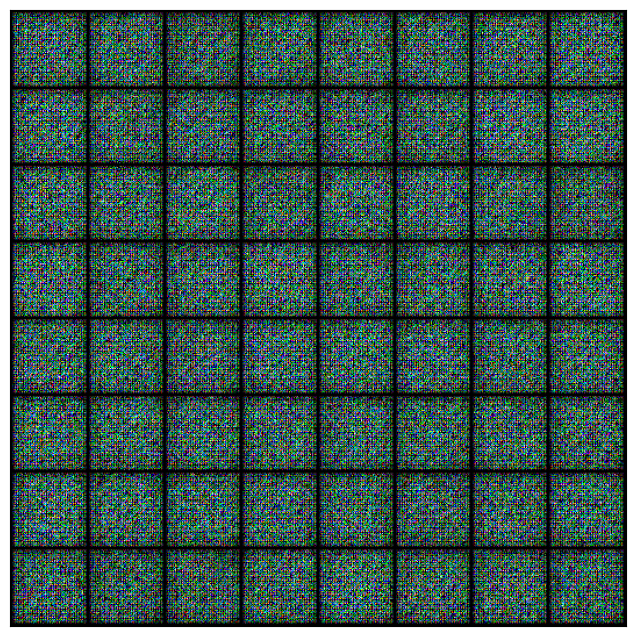

In [ ]:
save_samples(0,fixed_latent)

Saving generated-images-0020.png


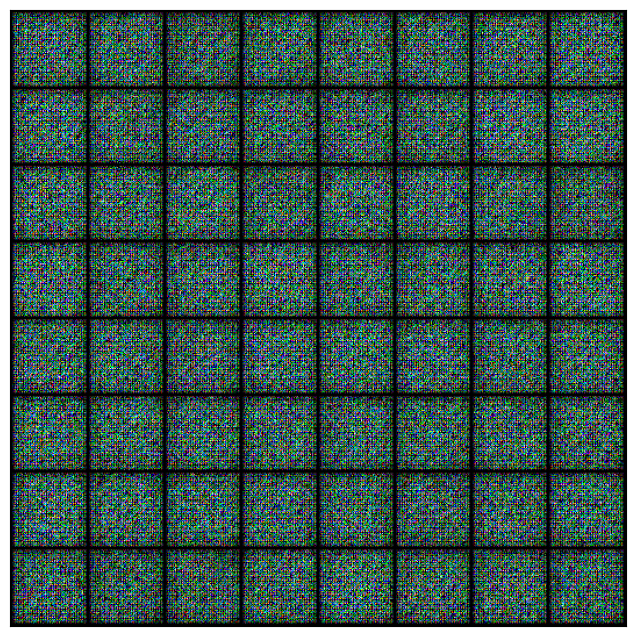

In [ ]:
save_samples(20,fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs,lr,start_idx=1):
  torch.cuda.empty_cache()
  losses_g=[]
  losses_d=[]
  real_scores=[]
  fake_scores=[]

  opt_d=torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.999))
  opt_g=torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(train_dl):
      loss_d,real_score,fake_score= train_discriminator(real_images,opt_d)
      loss_g = train_generator(opt_g)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)
    print("Epoch[{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

    save_samples(epoch+start_idx,fixed_latent,show=False)
  return losses_g,losses_d,real_scores,fake_scores

In [ ]:
lr =0.0002
epochs=15

In [ ]:
history= fit(epochs,lr)

  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[1/15], loss_g: 4.3671, loss_d: 0.3140, real_score: 0.9093, fake_score: 0.1639
Saving generated-images-0001.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[2/15], loss_g: 4.7862, loss_d: 0.1088, real_score: 0.9144, fake_score: 0.0099
Saving generated-images-0002.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[3/15], loss_g: 3.1093, loss_d: 0.1921, real_score: 0.9900, fake_score: 0.1358
Saving generated-images-0003.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[4/15], loss_g: 3.5754, loss_d: 0.3454, real_score: 0.7629, fake_score: 0.0108
Saving generated-images-0004.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[5/15], loss_g: 4.9931, loss_d: 0.1023, real_score: 0.9505, fake_score: 0.0450
Saving generated-images-0005.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[6/15], loss_g: 5.5841, loss_d: 0.0477, real_score: 0.9697, fake_score: 0.0129
Saving generated-images-0006.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[7/15], loss_g: 10.8321, loss_d: 0.9942, real_score: 0.9908, fake_score: 0.5501
Saving generated-images-0007.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[8/15], loss_g: 9.5006, loss_d: 0.3745, real_score: 0.9684, fake_score: 0.2580
Saving generated-images-0008.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[9/15], loss_g: 6.9241, loss_d: 0.3225, real_score: 0.9783, fake_score: 0.2388
Saving generated-images-0009.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[10/15], loss_g: 7.6467, loss_d: 0.1293, real_score: 0.9826, fake_score: 0.0960
Saving generated-images-0010.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[11/15], loss_g: 4.3592, loss_d: 0.2866, real_score: 0.8659, fake_score: 0.0990
Saving generated-images-0011.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[12/15], loss_g: 4.1524, loss_d: 0.1822, real_score: 0.8781, fake_score: 0.0279
Saving generated-images-0012.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[13/15], loss_g: 3.8274, loss_d: 0.1316, real_score: 0.9395, fake_score: 0.0563
Saving generated-images-0013.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[14/15], loss_g: 4.4171, loss_d: 0.1231, real_score: 0.9244, fake_score: 0.0344
Saving generated-images-0014.png


  0%|          | 0/115 [00:00<?, ?it/s]

Epoch[15/15], loss_g: 3.8707, loss_d: 0.2621, real_score: 0.9676, fake_score: 0.1852
Saving generated-images-0015.png


In [ ]:
losses_g,losses_d,real_scores,fake_scores=history

In [ ]:
torch.save(generator.state_dict(),'Generator.pth')
torch.save(discriminator.state_dict(),'Discriminator.pth')

In [ ]:
from IPython.display import Image

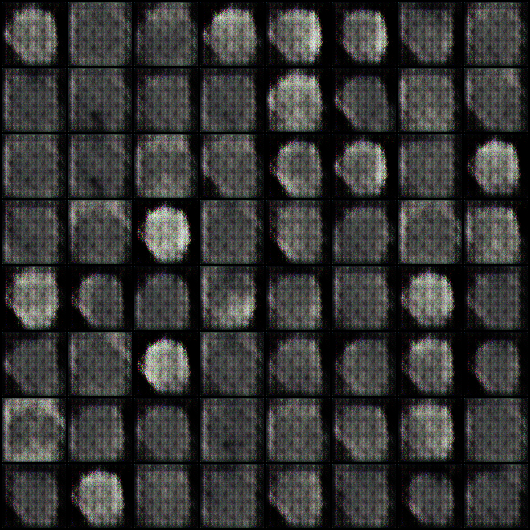

In [ ]:
Image('./generated/generated-images-0001.png')

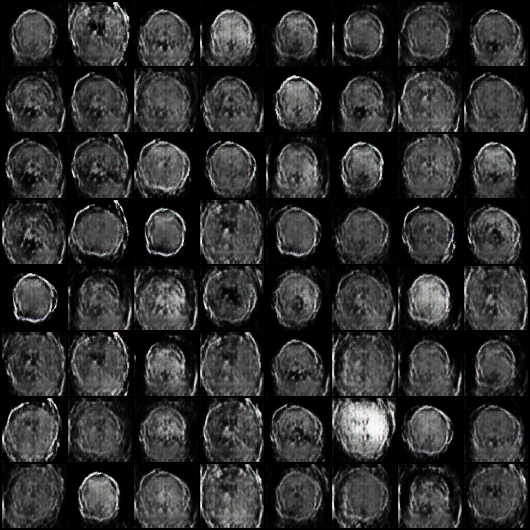

In [ ]:
Image('./generated/generated-images-0007.png')

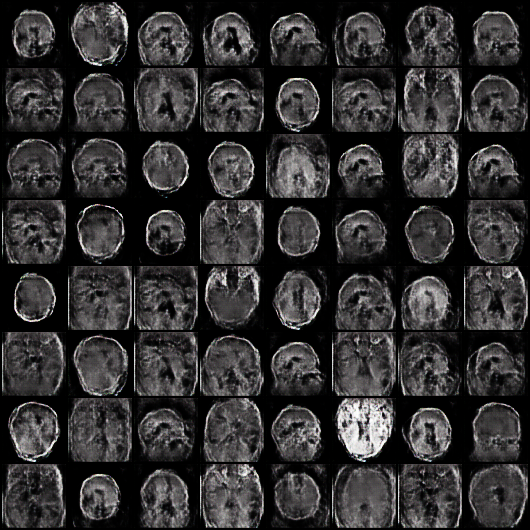

In [ ]:
Image('./generated/generated-images-0015.png')